## EEP 153 Project 4

In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems. The goal of this project is to analyze the differences in diet within the population of Senegal based on household characteristics. After estimating a demand system for Senegal, we want to investigate the relationship between diet, budget, and prices.

There are two prerequisites; the first is the `CFEDemands` python
module.  The following code installs this module:

In [3]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Our country of interest is Senegal. Professor Ligon provided a spreadsheet with household characteristics, food expenditures, and food prices for Senegal that can be found at https://docs.google.com/spreadsheets/d/1s01A3lSZdlcHQPIfJcLdI3k-NtQkTInia1fDAg7W5eQ/

In order to conduct nutritional analysis, we added columns for Recommended Daily Intake and Food Composition tables and created a new spreadsheet for Senegal that can be found at https://docs.google.com/spreadsheets/d/1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E/


#### Structure of the Spreadsheet



Our spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
includes a household id; the column &ldquo;t&rdquo; includes an
indicator for the year or period (e.g., 2019);
the column &ldquo;m&rdquo; is an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Senegal&rdquo;).

The triple (i,t,m) serves as the index of the constructed
dataframes.  

Before manipulating the data, we had to preprocess it by saving each sheet as its own CSV and translating the food names from French to English.

#### From Sheet to DataFrame to Regression Object



We begin by loading in our CSVs for each respective worksheet in our main Senegal spreadsheet and converting them to dataframes.



In [4]:
import pandas as pd
import numpy as np
import cfe
#from eep153_tools.sheets import read_sheets

# === 1. Food Expenditures ===

x = pd.read_csv("./Data/Malawi_Food_Expenditures(2019-20).csv", header= 0, index_col=0).reset_index()
x = x.set_index(['i', 't', 'm', 'j']).squeeze()

# === 2. Food Prices ===
p = pd.read_csv('./Data/Malawi_Food_Prices(2019-20).csv', header= 0).set_index(['t', 'm', 'j', 'u'])

# Compute medians of prices for each (t, m, j, u)
p = p.groupby(['t', 'm', 'j', 'u']).median()

# Keep only Kg unit
p = p.xs('kg', level="u").squeeze().unstack('j')

# Find intersection of goods between price data and expenditure data
common_goods = list(set(p.columns).intersection(set(x.index.get_level_values('j'))))

# Filter both datasets to those goods
p = p[common_goods].T

# === 3. Household Characteristics ===
d = pd.read_csv('./Data/Malawi_Household_Characteristics.csv', header= 0)
d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Group expenditures and clean
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x = x.replace(0, np.nan)

# Take logs of expenditures
y = np.log(x)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)


In [5]:
d

,,k,boys,women,girls,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1.098612
315538160189,2019-20,Southern,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1.098612
315538160190,2019-20,Southern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000


This gives a dataframe of household characteristics $d$ with a simple structure.



In [6]:
d.head()

,,k,boys,women,girls,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [7]:
y.head()

i             t        m      j              
101011000014  2019-20  North  Chinese cabbage    5.298317
                              Chips (vendor)     6.214608
                              Cooking oil        5.298317
                              Onion              4.605170
                              Salt               5.010635
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [8]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [9]:
result.predicted_expenditures()

i             t        m         j                                        
101011000071  2019-20  North     Avocado                                       383.113800
                                 Banana                                        494.138806
                                 Bean, brown                                   635.824825
                                 Beef                                         2522.707026
                                 Biscuits                                      453.344044
                                                                                 ...     
315538160239  2019-20  Southern  Tomato                                        348.301365
                                 White sweet potato                            293.415618
                                 Wild fruit (masau, malambe, etc)              128.500366
                                 Yeast, baking powder, bicarbonate of soda      38.553488
                         

Now we can compare predicted log expenditures with actual:



y  \
i            t       m        j                                                     
101011000014 2019-20 North    Chinese cabbage                            5.298317   
                              Chips (vendor)                             6.214608   
                              Cooking oil                                5.298317   
                              Onion                                      4.605170   
                              Salt                                       5.010635   
...                                                                           ...   
315538160239 2019-20 Southern Tomato                                     5.703782   
                              White sweet potato                              NaN   
                              Wild fruit (masau, malambe, etc)                NaN   
                              Yeast, baking powder, bicarbonate of soda       NaN   
                              Yoghurt                                         NaN   

                                                                             yhat  
i            t       m        j                                                    
101011000014 2019-20 North    Chinese cabbage                                 NaN  
                              Chips (vendor)                                  NaN  
                              Cooking oil                                     NaN  
                              Onion                                           NaN  
                              Salt                                            NaN  
...                                                                           ...  
315538160239 2019-20 Southern Tomato                                     5.695644  
                              White sweet potato                         5.508403  
                              Wild fruit (masau, malambe, etc)           4.728829  
                              Yeast, baking powder, bicarbonate of soda  3.462892  
                              Yoghurt                                    5.958665  

[336437 rows x 2 columns]

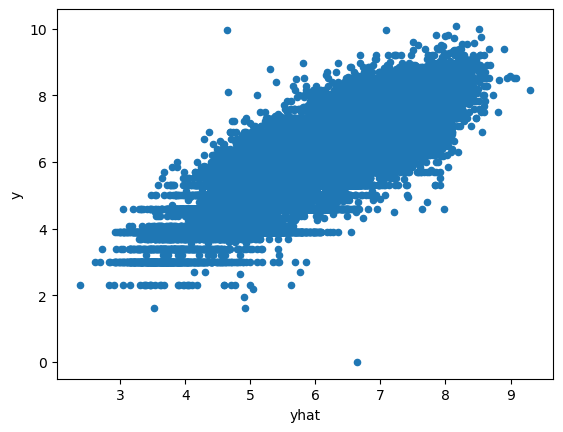

In [10]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Here we use a plot to visualize *Frisch elasticities*, with confidence intervals. Higher values means that the good is more elastic in response to changes in income.


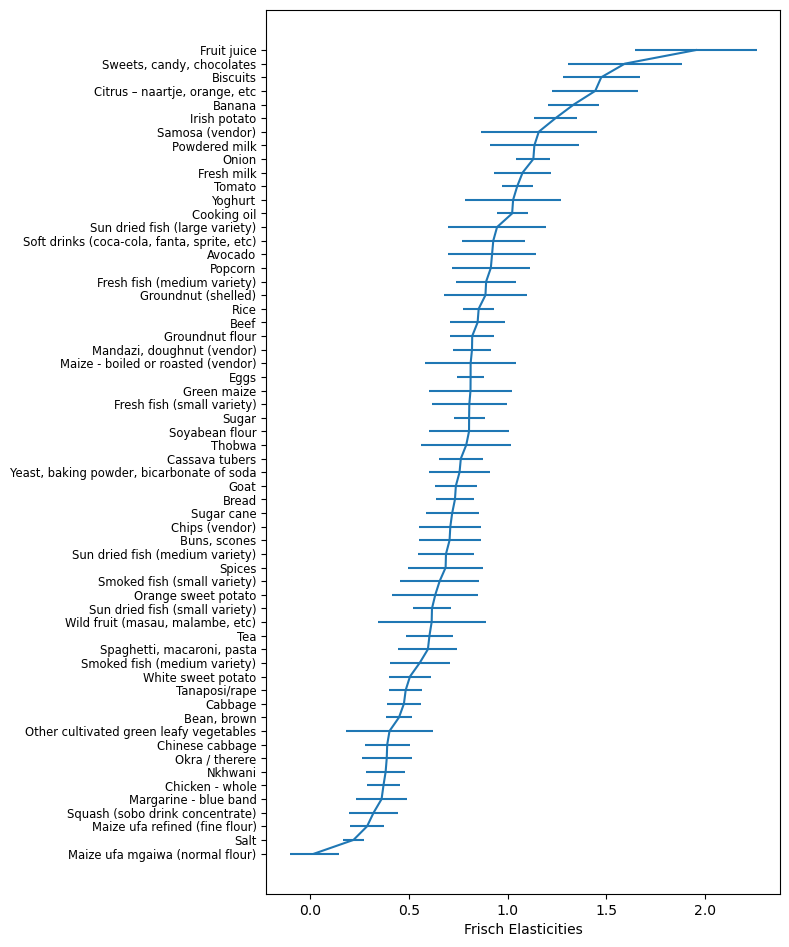

In [11]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [12]:
result.get_beta()

j
Avocado                                        0.921294
Banana                                         1.334759
Bean, brown                                    0.450482
Beef                                           0.848220
Biscuits                                       1.473836
Bread                                          0.733515
Buns, scones                                   0.706256
Cabbage                                        0.475333
Cassava tubers                                 0.763293
Chicken - whole                                0.371848
Chinese cabbage                                0.390740
Chips (vendor)                                 0.710060
Citrus – naartje, orange, etc                  1.443437
Cooking oil                                    1.022874
Eggs                                           0.812722
Fresh fish (medium variety)                    0.891365
Fresh fish (small variety)                     0.806225
Fresh milk                                    

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [13]:
result.get_gamma()

k,boys,women,girls,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Avocado,0.082647,-0.090723,0.144770,0.092839,-0.129338,-0.118272,-0.049004,-0.061163,-0.067161,-0.067830,0.038878,-0.063025,-0.044142,0.266145,0.134229,0.212044,0.292025,-0.113853,0.040441,5.516114
Banana,0.104810,0.073983,0.058964,0.073886,-0.196715,-0.099001,-0.114737,-0.121824,-0.091441,-0.077725,0.043976,0.014603,0.064162,0.188511,0.262776,0.166508,0.210675,0.061876,-0.125813,5.872214
"Bean, brown",0.014614,0.006570,0.030126,0.076077,-0.007089,-0.069699,0.027749,-0.027467,0.061507,0.024705,-0.020495,0.021717,-0.024224,0.001893,-0.008380,0.028232,0.061621,0.057314,0.266043,6.317071
Beef,0.065358,-0.045032,0.140557,0.010509,-0.108395,-0.168342,-0.129444,-0.200415,-0.081508,-0.154756,0.016466,-0.016846,0.076641,0.165125,0.160422,0.254164,0.141686,0.216594,0.062565,7.604313
Biscuits,0.089625,-0.111137,0.202924,0.023444,-0.196408,-0.155116,-0.095067,-0.269942,-0.098385,-0.161057,0.035065,-0.036240,0.052660,0.323296,0.225794,0.377689,0.189411,0.013156,-0.275774,5.804591
Bread,0.027696,-0.026787,0.023645,-0.000171,-0.160218,-0.122044,-0.075374,-0.088141,-0.077322,-0.016999,-0.024068,-0.009209,0.107657,0.096227,0.175944,0.121870,0.080906,0.015154,0.282308,6.704532
"Buns, scones",0.029256,-0.008974,0.005267,0.021913,-0.110431,-0.035423,-0.061614,-0.055248,-0.036377,-0.087840,-0.051052,-0.031513,0.072326,0.041499,0.138298,0.131329,0.100019,0.033490,0.299649,6.073001
Cabbage,0.022490,-0.004530,0.036722,0.030964,-0.002503,-0.059305,0.006937,-0.033518,-0.035650,-0.014339,-0.009136,0.079665,0.035686,-0.030627,0.020633,0.036823,0.037488,0.053492,0.104331,5.444805
Cassava tubers,0.061342,-0.013895,0.029636,-0.023772,-0.123503,-0.125989,-0.041878,-0.062891,-0.040469,-0.060344,0.006801,-0.000595,0.069783,0.117554,0.097140,0.090437,0.069695,0.057569,0.324469,5.713932


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

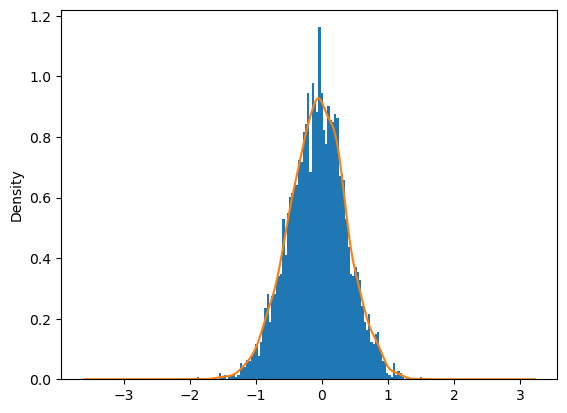

In [14]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [15]:
# Save the regression result
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [16]:

result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [17]:


# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [18]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [19]:
pbar.head()

j
Avocado         245.233026
Banana          412.696593
Bean, brown     980.704749
Beef           2549.298987
Biscuits       1111.150515
dtype: float64

Available goods: ['Avocado', 'Banana', 'Bean, brown', 'Beef', 'Biscuits', 'Bread', 'Buns, scones', 'Cabbage', 'Cassava tubers', 'Chicken - whole', 'Chinese cabbage', 'Chips (vendor)', 'Citrus – naartje, orange, etc', 'Cooking oil', 'Eggs', 'Fresh fish (medium variety)', 'Fresh fish (small variety)', 'Fresh milk', 'Fruit juice', 'Goat', 'Green maize', 'Groundnut (shelled)', 'Groundnut flour', 'Irish potato', 'Maize - boiled or roasted (vendor)', 'Maize ufa mgaiwa (normal flour)', 'Maize ufa refined (fine flour)', 'Mandazi, doughnut (vendor)', 'Margarine - blue band', 'Nkhwani', 'Okra / therere', 'Onion', 'Orange sweet potato', 'Other cultivated green leafy vegetables', 'Popcorn', 'Powdered milk', 'Rice', 'Salt', 'Samosa (vendor)', 'Smoked fish (medium variety)', 'Smoked fish (small variety)', 'Soft drinks (coca-cola, fanta, sprite, etc)', 'Soyabean flour', 'Spaghetti, macaroni, pasta', 'Spices', 'Squash (sobo drink concentrate)', 'Sugar', 'Sugar cane', 'Sun dried fish (large variety)', 

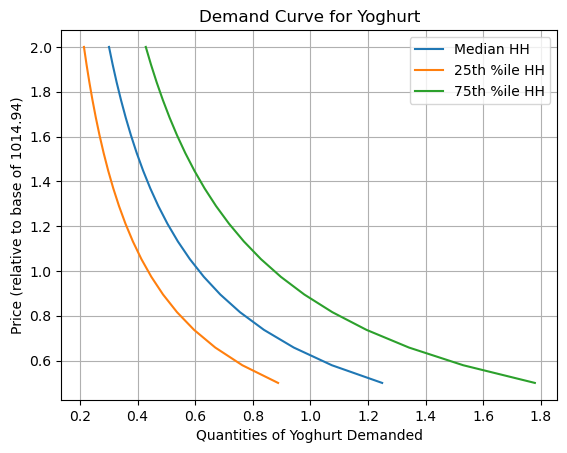

In [20]:
import matplotlib.pyplot as plt


#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'Yoghurt'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

##### Engel Curves



Engel curves trace out how demand changes with budget:



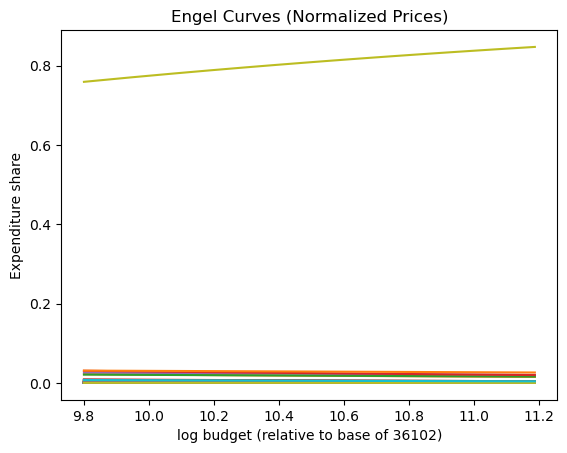

In [21]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [22]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

j
Chicken - whole                    0.101009
Beef                               0.057202
Goat                               0.050539
Margarine - blue band              0.044620
Smoked fish (medium variety)       0.043144
Sun dried fish (medium variety)    0.032975
Sun dried fish (small variety)     0.029642
Squash (sobo drink concentrate)    0.029224
Smoked fish (small variety)        0.027243
Fresh fish (medium variety)        0.025916
Name: quantities, dtype: float64

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

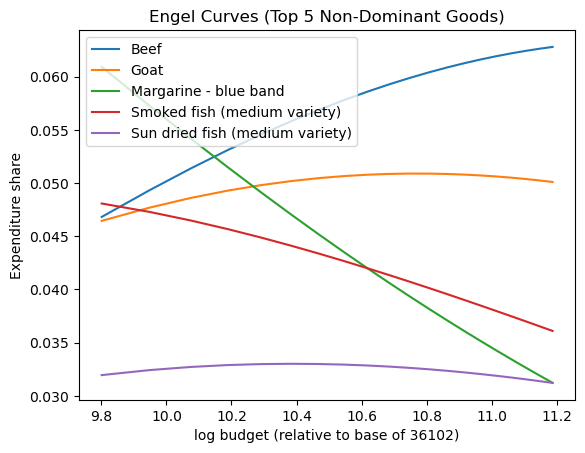

In [23]:
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

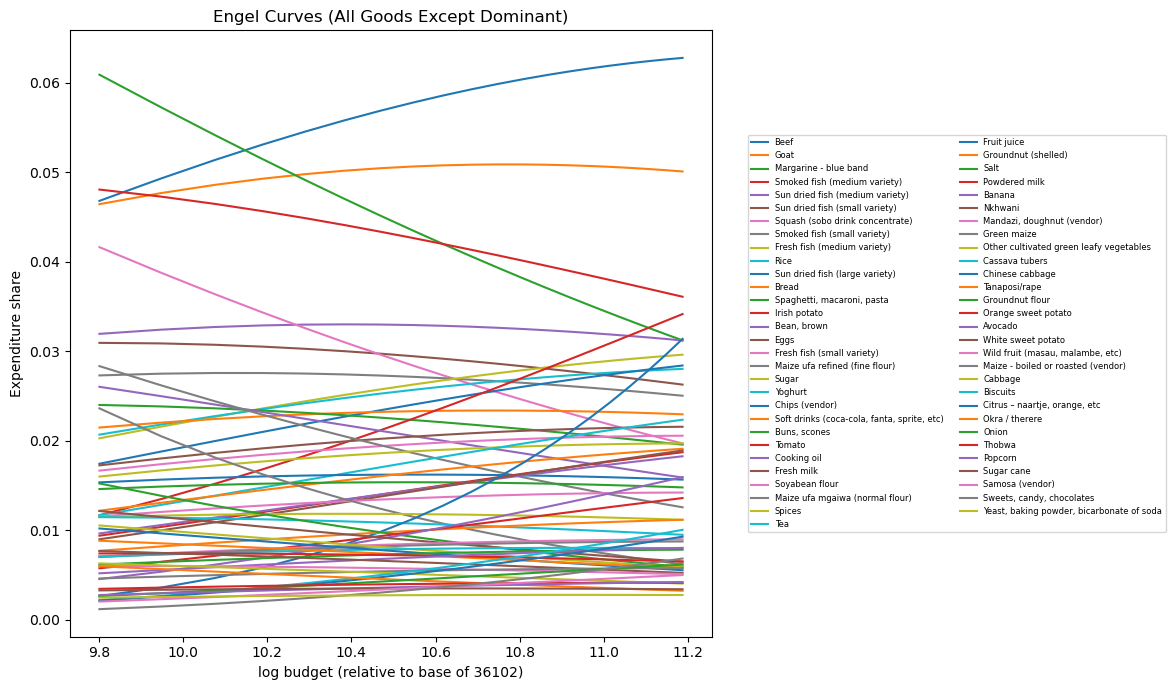

In [24]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



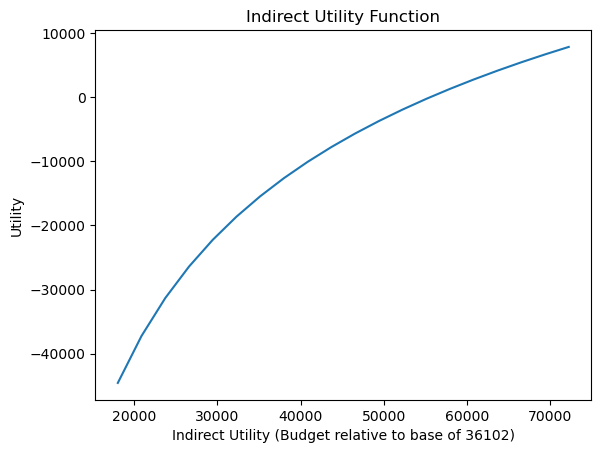

In [25]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()

# Nutritional Analysis of Diet

In [26]:
fct = pd.read_csv("./Data/FCT.csv", index_col = 0)
fct.head()

,k,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,,
Avocado,Avocat,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),Haricots (secs),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),Haricots (frais),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,Bœuf,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),Bœuf (rôti),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [27]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('./Data/Malawi_Food_Expenditures(2019-20).csv')
expend

,i,t,m,j,Expenditure
0,101011000014,2019-20,North,Chinese cabbage,200
1,101011000014,2019-20,North,Chips (vendor),500
2,101011000014,2019-20,North,Cooking oil,200
3,101011000014,2019-20,North,Onion,100
4,101011000014,2019-20,North,Salt,150
...,...,...,...,...,...
148969,315538160239,2019-20,Southern,Salt,50
148970,315538160239,2019-20,Southern,"Soft drinks (coca-cola, fanta, sprite, etc)",500
148971,315538160239,2019-20,Southern,"Termites, other insects (eg ngumbi, caterpillar)",200
148972,315538160239,2019-20,Southern,Thobwa,200


In [28]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('./Data/Malawi_Food_Expenditures(2019-20).csv')
exp = get_clean_sheet('./Data/Malawi_Food_Expenditures(2019-20).csv')

exp_wide = expend.pivot_table(
    index=["i", "t", "m"],   # The keys identifying each row
    columns="j",            # The column you want to spread out
    values="Expenditure",   # What goes in the cells
    aggfunc="sum",          # How to aggregate if you have repeats
)

# If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
expend = exp_wide.reset_index()

if 'm' not in expend.columns:
    expend['m'] = 1

expend = expend.set_index(['i','t','m'])
expend.columns.name = 'j'

expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expend = expend.replace(0,np.nan)

# Get HH characteristics...
hhc = get_clean_sheet('./Data/Malawi_Household_Characteristics.csv')

if 'm' not in hhc.columns:
    hhc['m'] = 1

hhc = hhc.set_index(['i','t','m'])
hhc.columns.name = 'k'

hhc = hhc.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = pd.read_csv("./Data/Malawi_Food_Prices(2019-20).csv")

# Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
#p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")

# Convert to numeric if needed
p["Price"] = pd.to_numeric(p["Price"], errors="coerce")

# Pivot so each unique `j` becomes a column and
# each (t, m) is one row
p_wide = p.pivot_table(
    index=["t","m"],
    columns="j",
    values="Price",
    aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
) #.reset_index()

p_wide.columns.name = None  # remove the pivoted index name if desired

p = p_wide #.set_index('t')

fct = get_clean_sheet('./Data/FCT.csv')

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet('./Data/RDI.csv')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [29]:

result = cfe.Regression(y=np.log(expend.stack()),d=hhc)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Fruit juice                                    1.953511
Sweets, candy, chocolates                      1.593155
Biscuits                                       1.473836
Citrus – naartje, orange, etc                  1.443437
Banana                                         1.334759
Irish potato                                   1.242634
Samosa (vendor)                                1.157753
Powdered milk                                  1.135466
Onion                                          1.130243
Fresh milk                                     1.075878
Tomato                                         1.048691
Yoghurt                                        1.027837
Cooking oil                                    1.022874
Sun dried fish (large variety)                 0.946686
Soft drinks (coca-cola, fanta, sprite, etc)    0.927463
Avocado                                        0.921294
Popcorn                                        0.915088
Fresh fish (medium variety)                   

# Top 10 most consumed foods


In [30]:
import pandas as pd
import numpy as np
import plotly.express as px

def plot_top_10_foods_by_demographics(
    hhc,         # Household composition DataFrame; must be MultiIndexed by (i, t, m)
    expend,      # Expenditures DataFrame; same (i, t, m) index and food items as columns
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None,
    nutrient_ratio=None,  # Optional: Nutrient profile DataFrame with same index and food columns
    # These column lists define which columns to sum over for each demographic group:
    male_cols=["M 19-30", "M 31-50", "M 51+"],
    female_cols=["F 19-30", "F 31-50", "F 51+"],
    kid_cols=["F 00-03", "M 00-03", "F 04-08", "M 04-08", "F 09-13", "M 09-13", "F 14-18", "M 14-18"]
):
    """
    Filters the households based on demographic ranges and plots the top 10 consumed foods
    among those households using total expenditure. If nutrient_ratio is provided, the summed
    nutrient information for each top food is added as hover text.

    Parameters
    ----------
    hhc : pd.DataFrame
        Household characteristics DataFrame indexed by (i, t, m). It must contain columns that
        indicate counts of household members using the keys in male_cols, female_cols, and kid_cols.
    expend : pd.DataFrame
        Expenditures DataFrame indexed by (i, t, m) with food items (j) as columns. The values
        are the expenditure amounts.
    min_males, max_males : int or None
        Minimum (and maximum, if provided) number of adult males.
    min_females, max_females : int or None
        Minimum (and maximum, if provided) number of adult females.
    min_kids, max_kids : int or None
        Minimum (and maximum, if provided) number of children.
    nutrient_ratio : pd.DataFrame, optional
        Nutrient profile DataFrame (indexed by (i, t, m) with food items as columns). If provided,
        the summed nutrient values (over the filtered households) are shown in the bar hover text.
    male_cols : list of str
        List of column names for adult males.
    female_cols : list of str
        List of column names for adult females.
    kid_cols : list of str
        List of column names for children.
    """
    
    # --- 1) Compute total counts for each household ---
    hhc = hhc.copy()  # avoid modifying the original
    hhc["male_adults"] = hhc[male_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_cols].sum(axis=1)
    hhc["kids"] = hhc[kid_cols].sum(axis=1)
    
    # --- 2) Build the Boolean mask based on the demographic ranges ---
    mask = (hhc["male_adults"] >= min_males)
    if max_males is not None:
        mask &= (hhc["male_adults"] <= max_males)
        
    mask &= (hhc["female_adults"] >= min_females)
    if max_females is not None:
        mask &= (hhc["female_adults"] <= max_females)
        
    mask &= (hhc["kids"] >= min_kids)
    if max_kids is not None:
        mask &= (hhc["kids"] <= max_kids)
    
    # --- 3) Filter the household composition and expenditure data ---
    hhc_filtered = hhc[mask]
    # Ensure that the expenditure DF is filtered by the common indices
    common_idx = hhc_filtered.index.intersection(expend.index)
    expend_filtered = expend.loc[common_idx]
    
    if expend_filtered.empty:
        print("No households match the specified demographic ranges!")
        return

    # --- 4) Sum expenditures for each food item and get the top 10 ---
    total_expenditures = expend_filtered.sum(axis=0)
    top_10 = total_expenditures.sort_values(ascending=False).head(20)
    
    # Prepare a DataFrame for plotting
    plot_df = top_10.reset_index()
    plot_df.columns = ["Food", "Expenditure"]
    
    # --- 5) If nutrient_ratio is provided, add nutrient info to the hover data ---
    if nutrient_ratio is not None:
        # Assume nutrient_ratio has the same household indexing and food items as columns.
        nutrient_filtered = nutrient_ratio.loc[common_idx]
        nutrient_sum = nutrient_filtered.sum(axis=0)
        # Create a hover info string for each top food.
        # (Customize formatting as needed.)
        nutrient_info = {}
        for food in plot_df["Food"]:
            if food in nutrient_sum.index:
                nutrient_info[food] = f"Nutrient total: {nutrient_sum[food]:.2f}"
            else:
                nutrient_info[food] = "Nutrient data N/A"
        # Map the nutrient info to our plot_df
        plot_df["Nutrient Info"] = plot_df["Food"].map(nutrient_info)
    
    # --- 6) Create the interactive bar chart using Plotly Express ---
    if nutrient_ratio is not None:
        fig = px.bar(
            plot_df,
            x="Food",
            y="Expenditure",
            hover_data={"Nutrient Info": True, "Expenditure":":.2f"}
        )
    else:
        fig = px.bar(
            plot_df,
            x="Food",
            y="Expenditure",
            hover_data={"Expenditure":":.2f"}
        )
    
    fig.update_layout(
        title="Top 20 Consumed Foods by Selected Household Characteristics",
        xaxis_title="Food Item",
        yaxis_title="Total Expenditure"
    )
    fig.show()


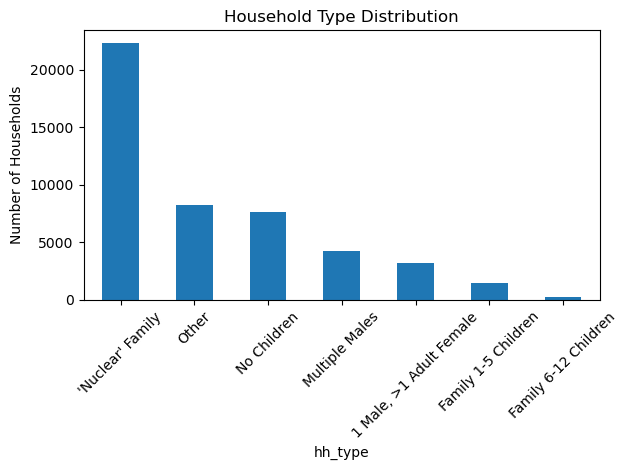

In [31]:

    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
hhc1 = hhc.copy()

def classify_household(row):
    if row["men"] == 1 and row["women"] == 1 and row["girls"]+row['boys'] > 0:
        return "'Nuclear' Family"
    elif row["men"] == 1 and row["women"] > 1 and row["girls"]+row['boys'] > 0:
        return "1 Male, >1 Adult Female"
    elif row["men"] > 1 and row["women"] <= 1 and row["girls"]+row['boys'] > 0:
        return "Multiple Males"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 1 and row["girls"]+row['boys'] <= 5:
        return "Family 1-5 Children"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 5 and row["girls"]+row['boys'] <= 12:
        return "Family 6-12 Children"
    elif row["men"] >= 0 and row["women"] >= 0 and row["girls"]+row['boys'] == 0:
        return "No Children"
    else:
        return "Other"
hhc["hh_type"] = hhc.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
#result.to_pickle('./foo.pickle')

result = cfe.regression.read_pickle('senegal_estimates.rgsn')
#result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')


# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#repeat
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    
nutrients


In [33]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    
nutrients

,,n,k,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,,
201022380102,2019-20,Central,NaN,9876.414882,247.438052,86.861836,2156.577735,1740.833190,1494.066130,60.798985,80.238959,7.538175,6.072613,554.486211,21.110778,5.917314,96.409757,38.076442
201032390010,2019-20,Central,NaN,4524.269597,123.807065,35.520021,942.160749,755.994473,652.415292,28.426393,37.604980,3.461623,2.767290,244.416965,11.590431,2.796369,38.549872,19.531056
201032390068,2019-20,Central,NaN,9249.942735,237.375353,78.156575,1987.291791,1627.336643,1389.700004,57.463456,75.842040,7.039669,5.712001,503.049298,20.803861,5.561829,85.604726,36.793247
201032390189,2019-20,Central,NaN,6021.859195,153.295027,51.236537,1299.824891,1099.641297,920.233090,37.413600,48.396391,4.673722,3.703228,375.939092,13.182556,3.588409,56.040641,23.294523
201042400040,2019-20,Central,NaN,7189.158177,179.128201,67.868594,1603.388448,1273.975448,1079.968735,43.933347,58.281990,5.536194,4.369860,428.811724,15.177775,4.456135,77.164747,27.666523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160174,2019-20,Southern,NaN,17136.418169,413.179244,179.040361,4024.705566,2864.877770,2502.149313,103.327044,140.918729,13.210691,10.428984,956.598002,33.500850,10.859911,210.509909,64.345722
315538160177,2019-20,Southern,NaN,11554.709655,309.936683,100.185117,2530.372228,1935.577331,1646.156183,72.860986,97.645325,8.940405,7.184835,612.619220,28.031213,7.278175,111.745177,48.876238
315538160189,2019-20,Southern,NaN,12913.843479,335.337841,118.433497,2899.180771,2166.159849,1854.018511,80.664746,108.677840,9.987472,8.036156,683.363423,29.288146,8.103549,134.101498,52.611352


In [34]:
hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
hhc.columns = hhc.columns.str.replace("51-99", "51+")
#hhc.columns = df.columns.str.replace("M 51-99", "M 51+")
hhc

,,k,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize,hh_type
i,t,m,,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910,'Nuclear' Family
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612,'Nuclear' Family
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759,'Nuclear' Family
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759,'Nuclear' Family
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759,'Nuclear' Family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1.098612,'Nuclear' Family
315538160189,2019-20,Southern,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1.098612,'Nuclear' Family
315538160190,2019-20,Southern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,No Children


In [35]:
#result.to_pickle('./foo.pickle')

result = cfe.regression.read_pickle('senegal_estimates.rgsn')
#result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')


# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#repeat
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    
nutrients

#^repeat

hhc = hhc[rdi.columns.tolist()]

hh_rdi = hhc@rdi.T 
#z = # ppl in household , rdi => add up all ppl in household
hh_rwi = hh_rdi*7

hh_rwi

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,78400.0,1631.0,1097.6,14000.0,49000.0,6370.0,483.0,11760.0,546.0,37240.0,198800.0,43.4,42.0,28700.0,84.0,45.5,2380.0,525.0,3220.0,343.0
10101002051,2004-05,North,36400.0,805.0,509.6,6650.0,21000.0,2730.0,210.0,5880.0,252.0,16870.0,86800.0,19.6,18.9,13300.0,39.9,21.0,1190.0,252.0,1575.0,161.0
10101002072,2004-05,North,68600.0,1393.0,960.4,11900.0,39900.0,5460.0,427.0,10010.0,462.0,28490.0,167300.0,37.1,35.7,24500.0,71.4,38.5,2065.0,448.0,2800.0,287.0
10101002079,2004-05,North,60200.0,1162.0,842.8,10500.0,37800.0,5460.0,420.0,8120.0,406.0,23240.0,161000.0,32.2,31.5,21000.0,63.0,33.6,1715.0,392.0,2660.0,245.0
10101002095,2004-05,North,72800.0,1456.0,1019.2,12600.0,46200.0,5460.0,434.0,10150.0,490.0,34300.0,182000.0,37.8,37.1,25200.0,75.6,40.6,2135.0,462.0,3080.0,315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,37800.0,805.0,529.2,6650.0,18900.0,2730.0,231.0,5530.0,252.0,13020.0,86800.0,20.3,19.6,13300.0,39.9,21.7,1260.0,252.0,1680.0,154.0
315538160189,2019-20,Southern,39200.0,847.0,548.8,7000.0,21000.0,2730.0,252.0,5880.0,266.0,13300.0,92400.0,21.0,20.3,14000.0,42.0,22.4,1330.0,259.0,1855.0,168.0
315538160190,2019-20,Southern,15400.0,392.0,215.6,2800.0,7000.0,910.0,56.0,2940.0,112.0,4900.0,32900.0,9.1,8.4,6300.0,16.8,9.1,630.0,105.0,840.0,77.0


In [36]:
#result.to_pickle('./foo.pickle')

result = cfe.regression.read_pickle('senegal_estimates.rgsn')
#result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')


# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#repeat
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    
nutrients

#^repeat

hhc = hhc[rdi.columns.tolist()]

hh_rdi = hhc@rdi.T 
#z = # ppl in household , rdi => add up all ppl in household
hh_rwi = hh_rdi*7

hh_rwi
# ^repeat

# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
#hh_rwi = required nutrients per week. 1 = adequate intake, <1 = not adequate
#%matplotlib inline
#nutrient_ratio['Protein'].hist(bins=200)
#plt.xlim(0, 5)

nutrient_ratio
#xhat.unstack('j')

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
101011000071,2019-20,North,0.215123,0.211127,0.141769,0.245596,0.068714,0.496334,0.212073,0.238277,0.273925,0.235345,0.026806,0.361989,0.189182,0.058358,0.169479
101011000126,2019-20,North,0.189295,0.214020,0.119446,0.230200,0.066355,0.383329,0.187049,0.225933,0.261269,0.222367,0.028314,0.360179,0.188749,0.053009,0.170979
101011000135,2019-20,North,0.188509,0.195767,0.116200,0.221623,0.054156,0.430467,0.207195,0.205956,0.248072,0.209465,0.026884,0.329627,0.179598,0.053568,0.142274
101011000183,2019-20,North,0.147095,0.180068,0.095374,0.194086,0.046450,0.291949,0.153477,0.183730,0.218033,0.185924,0.023206,0.277310,0.154189,0.049073,0.130368
101011000258,2019-20,North,0.139200,0.145001,0.081523,0.155373,0.041344,0.339411,0.151489,0.150178,0.178157,0.150606,0.019634,0.264006,0.131737,0.035453,0.109071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160174,2019-20,Southern,0.244806,0.283777,0.182694,0.319421,0.062010,0.458269,0.238081,0.287589,0.349489,0.281105,0.037960,0.443133,0.267485,0.098599,0.204272
315538160177,2019-20,Southern,0.305680,0.385015,0.189314,0.380507,0.102411,0.602988,0.315416,0.387481,0.440414,0.366573,0.046062,0.702537,0.335400,0.088687,0.317378
315538160189,2019-20,Southern,0.329435,0.395912,0.215804,0.414169,0.103150,0.679128,0.320098,0.408563,0.475594,0.395870,0.048812,0.697337,0.361766,0.100828,0.313163


In [37]:
def filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None
):
    """
    Return the rows (households) whose composition fits the given
    # of adult males, adult females, and children,
    along with their corresponding nutrient outcomes.
    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Identify which columns correspond to kids vs adult males/females
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
        "F 00-03", "M 00-03",
        "F 04-08", "M 04-08",
        "F 09-13", "M 09-13",
        "F 14-18", "M 14-18"
    ]
    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)

    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
   
    
    # 5) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    # also filter out expenditures
    com_idx = hhc_filtered.index.intersection(xhat.unstack('j').index)
    house_expend = xhat.unstack('j')
    house_expend = house_expend.loc[com_idx]
    house_expend['total expenditures'] = house_expend[:].sum(axis=1)
    expenditures_filtered = house_expend
   
    return hhc_filtered, nutrient_filtered, expenditures_filtered


# Ensure both DataFrames are set to (i, t, m) as their index
hhc.index.names = ["i","t","m"]
nutrient_ratio.index.names = ["i","t","m"]


In [38]:
xhat.unstack('j')

,,j,Avocado,Banana,"Bean, brown",Beef,Biscuits,Bread,"Buns, scones",Cabbage,Cassava tubers,Chicken - whole,...,Sun dried fish (small variety),"Sweets, candy, chocolates",Tanaposi/rape,Tea,Thobwa,Tomato,White sweet potato,"Wild fruit (masau, malambe, etc)","Yeast, baking powder, bicarbonate of soda",Yoghurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
101011000071,2019-20,North,383.113800,494.138806,635.824825,2522.707026,453.344044,1187.054766,532.294093,290.878869,420.452504,3137.879761,...,725.462984,145.372825,355.283769,123.748526,157.640971,849.251568,503.576745,144.986016,112.180457,810.800409
101011000126,2019-20,North,167.037612,199.268637,349.715414,1227.821759,193.907449,589.416394,289.360922,187.987353,212.211754,2364.478807,...,376.074888,82.621243,195.525626,85.332762,118.423738,353.676683,295.667806,108.595769,55.795815,324.732579
101011000135,2019-20,North,417.308458,553.723571,756.786799,2775.127697,488.884256,1388.816865,630.365842,338.625459,535.338720,3194.315965,...,933.155204,289.006417,378.920498,149.273912,246.349518,857.292360,716.997597,234.037986,98.536487,715.972385
101011000183,2019-20,North,214.770608,229.411661,502.863143,1418.984844,236.817942,774.073890,353.772320,247.282031,308.592162,2435.592325,...,491.932574,106.164526,266.711628,96.830333,155.368626,438.106792,405.402085,125.291053,74.119577,316.250845
101011000258,2019-20,North,223.435426,296.811765,477.435102,1797.709623,249.980855,795.133771,387.912868,230.644169,339.069127,2849.621019,...,586.797796,117.270217,267.878165,103.919341,166.270519,448.193571,453.337647,167.686605,58.351099,480.124087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160174,2019-20,Southern,457.370639,481.402456,825.284490,1997.240868,515.137820,1226.734665,581.450533,297.174153,496.488817,2624.783108,...,889.617724,213.361456,278.963854,152.993490,228.922545,858.867226,643.765232,134.197760,62.914323,859.485197
315538160177,2019-20,Southern,242.786496,374.525296,552.789548,1774.449196,391.461153,835.182927,480.360668,250.475985,357.082800,2742.752439,...,561.047862,144.565427,205.460100,131.818082,217.489411,606.017091,376.717053,100.169480,62.836756,783.598160
315538160189,2019-20,Southern,291.359625,415.778905,564.294414,1830.547798,442.731110,931.820220,515.766105,253.014977,383.760912,2603.331098,...,607.189254,197.662901,211.414055,138.493610,209.750749,656.122201,421.312353,138.650864,59.610759,873.876093


In [39]:
hhc_filtered, nutr_filt, expenditures_filtered = filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=100,
    min_females=0, max_females=100,
    min_kids=0, max_kids=100
)

hhc_filtered



,,k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+,male_adults,female_adults,kids
i,t,m,,,,,,,,,,,,,,,,,
101011000071,2019-20,North,0,0,0,0,1,0,0,0,1,1,1,0,0,1,2,2,1
101011000126,2019-20,North,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1
101011000135,2019-20,North,0,0,1,0,1,1,0,1,0,1,1,1,0,0,2,1,4
101011000183,2019-20,North,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,3
101011000258,2019-20,North,0,0,0,0,0,1,0,2,0,0,1,1,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160174,2019-20,Southern,0,0,1,1,2,0,0,0,1,0,0,1,0,0,1,1,4
315538160177,2019-20,Southern,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1
315538160189,2019-20,Southern,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1


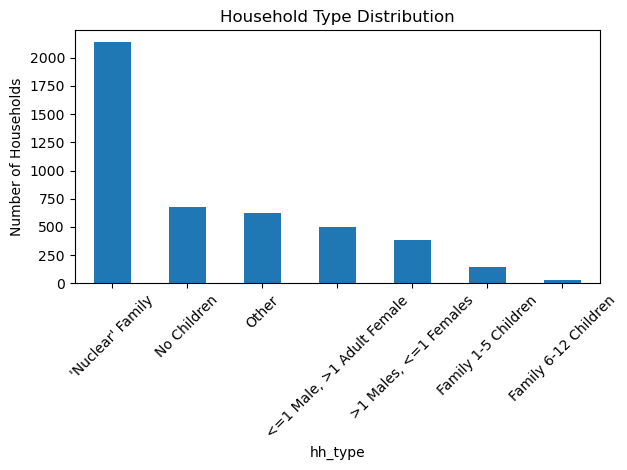

In [40]:

    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)


def classify_household(row):
    if row["male_adults"] == 1 and row["female_adults"] == 1 and row["kids"] > 0:
        return "'Nuclear' Family"
    elif row["male_adults"] <= 1 and row["female_adults"] > 1 and row["kids"] > 0 and row["kids"] <12:
        return "<=1 Male, >1 Adult Female"
    elif row["male_adults"] > 1 and row["female_adults"] <= 1 and row["kids"] > 0:
        return ">1 Males, <=1 Females"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 1 and row["kids"] <= 5:
        return "Family 1-5 Children"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 5 and row["kids"] <= 12:
        return "Family 6-12 Children"
    elif row["male_adults"] >= 0 and row["female_adults"] >= 0 and row["kids"] == 0:
        return "No Children"
    else:
        return "Other"
hhc_filtered["hh_type"] = hhc_filtered.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc_filtered["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


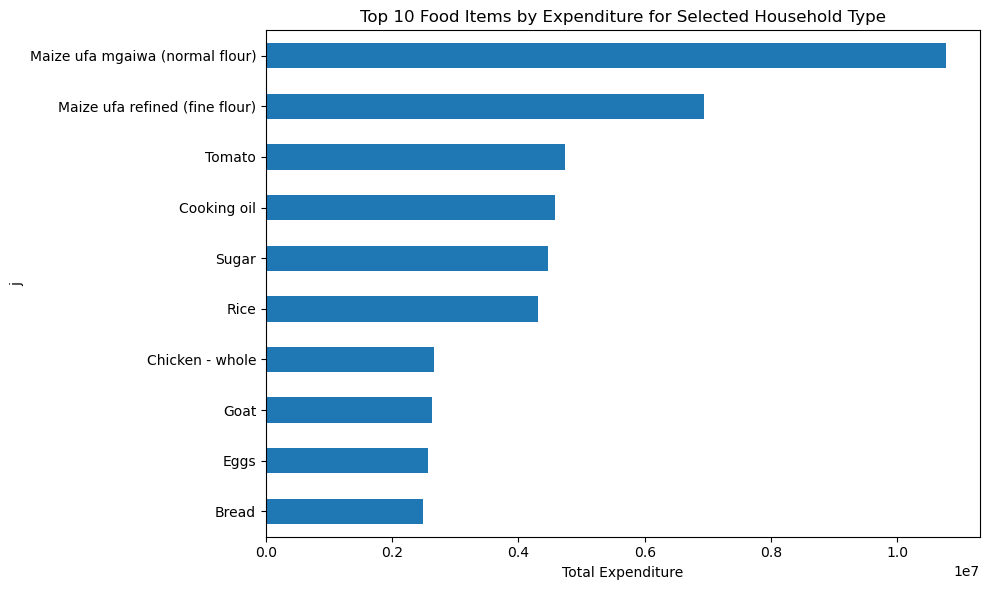

j
Maize ufa mgaiwa (normal flour)    10771598.0
Maize ufa refined (fine flour)      6943282.0
Tomato                              4739873.0
Cooking oil                         4579317.0
Sugar                               4470600.0
Rice                                4310261.0
Chicken - whole                     2658350.0
Goat                                2626256.0
Eggs                                2574608.0
Bread                               2487899.0
dtype: float64

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_top_foods_by_household(
    hhc,
    expend,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None,
    top_n=10
):
    """Filters households by demographic range and plots top consumed foods by expenditure."""

    # Set multi-index if not already
    hhc.index.names = ['i', 't', 'm']
    expend.index.names = ['i', 't', 'm']
    hhc.index.names = ['i', 't', 'm']
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
            "F 00-03", "M 00-03",
            "F 04-08", "M 04-08",
            "F 09-13", "M 09-13",
            "F 14-18", "M 14-18"
        ]
    

    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)
    
    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
    #common_idx = hhc_filtered.index.intersection(expend.index)
    #expend_filtered = expend.loc[common_idx]

    # Sum expenditures per food
    #top_expenditures = expend_filtered.sum().sort_values(ascending=False).head(top_n)
    top_expenditures = expend.sum().sort_values(ascending=False).head(top_n)
    # Plot
    plt.figure(figsize=(10, 6))
    top_expenditures.sort_values().plot(kind='barh')
    plt.title(f"Top {top_n} Food Items by Expenditure for Selected Household Type")
    plt.xlabel("Total Expenditure")
    plt.tight_layout()
    plt.show()

    return top_expenditures

#example
plot_top_foods_by_household(hhc, expend, min_males=1, max_females=4, min_kids=1)



In [42]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Household Characteristic - All Households

Average Weekly Food Expenditures: $38929.66 ($67.27 USD)


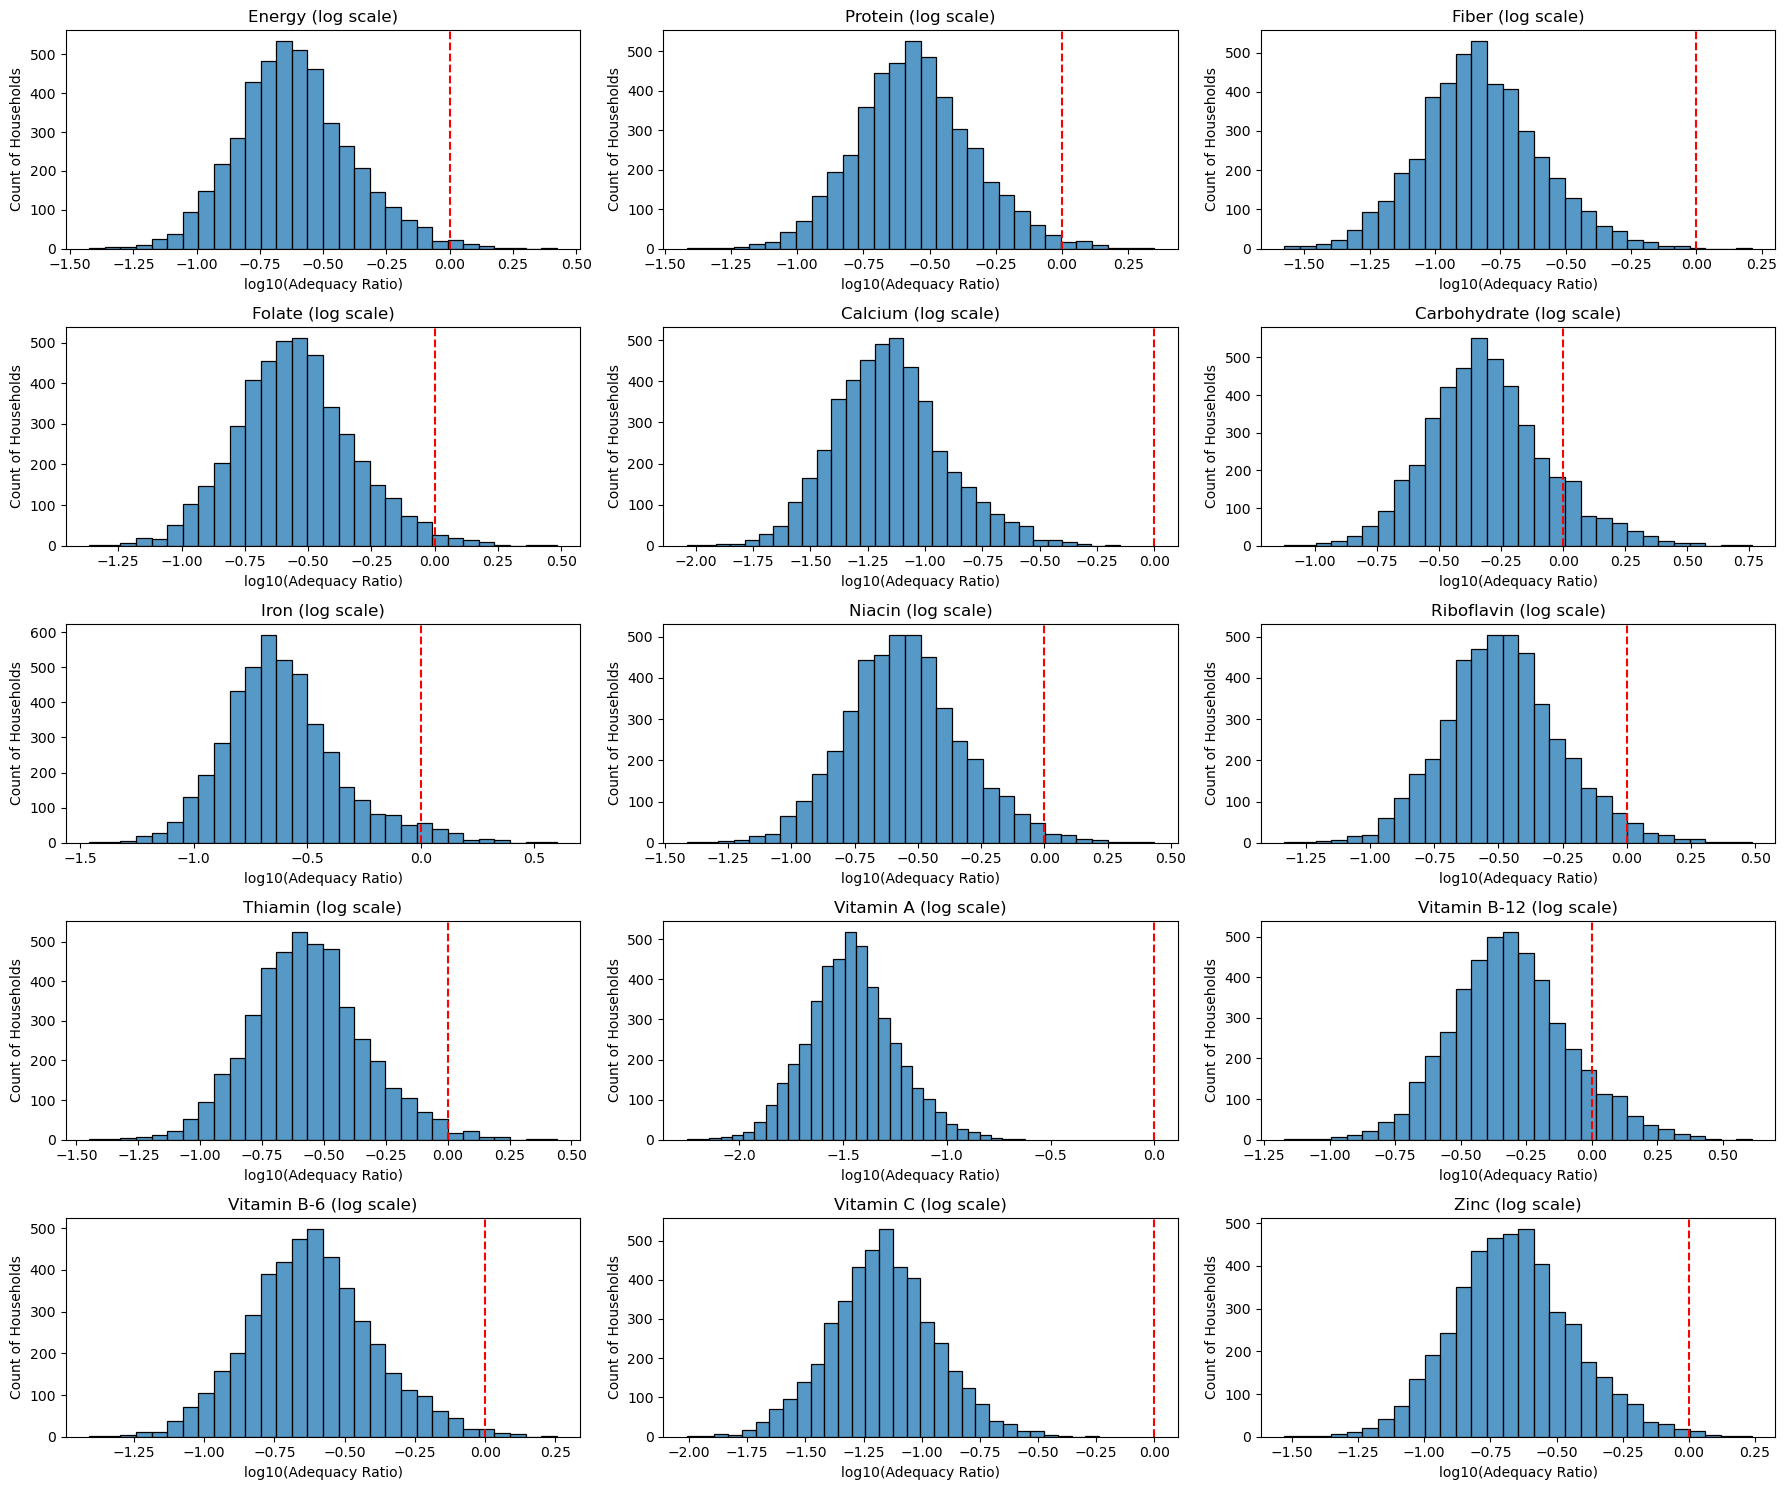

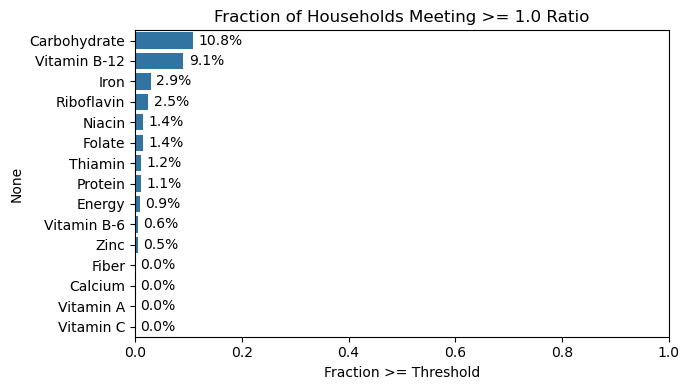

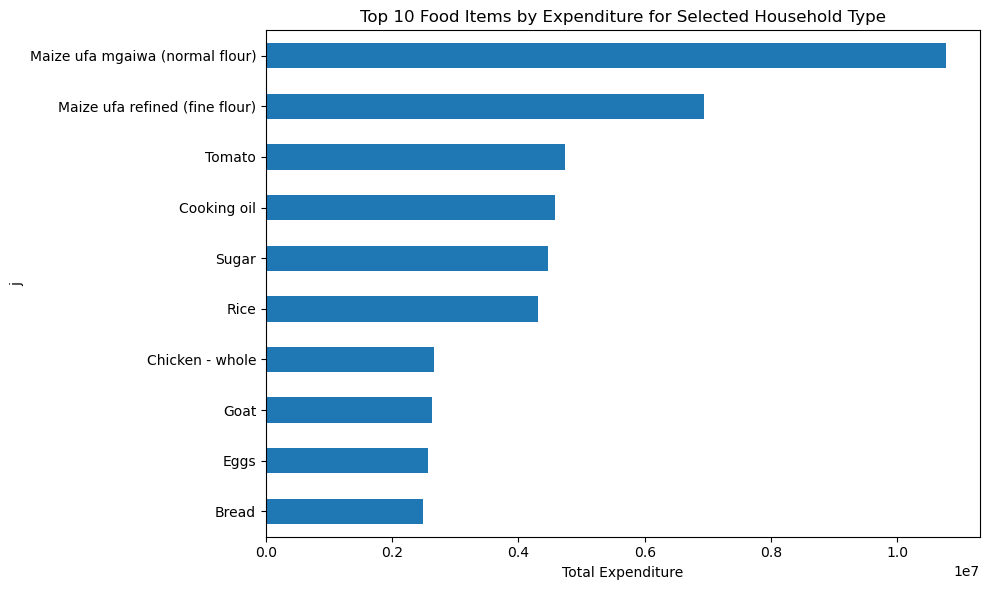

j
Maize ufa mgaiwa (normal flour)    10771598.0
Maize ufa refined (fine flour)      6943282.0
Tomato                              4739873.0
Cooking oil                         4579317.0
Sugar                               4470600.0
Rice                                4310261.0
Chicken - whole                     2658350.0
Goat                                2626256.0
Eggs                                2574608.0
Bread                               2487899.0
dtype: float64

In [43]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100        # e.g. up to 2 kids
)
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100)

In [44]:

print(f'# households:{hhc_sub.shape}')
#analyze_nutritional_adequacy(nut_sub)

# households:(4489, 17)


# Household Characteristic-  <=1 Adult Males, >1 Adult female, 1+ children

# households:(500, 17)
Average Weekly Food Expenditures: $45344.02 ($78.35 USD)


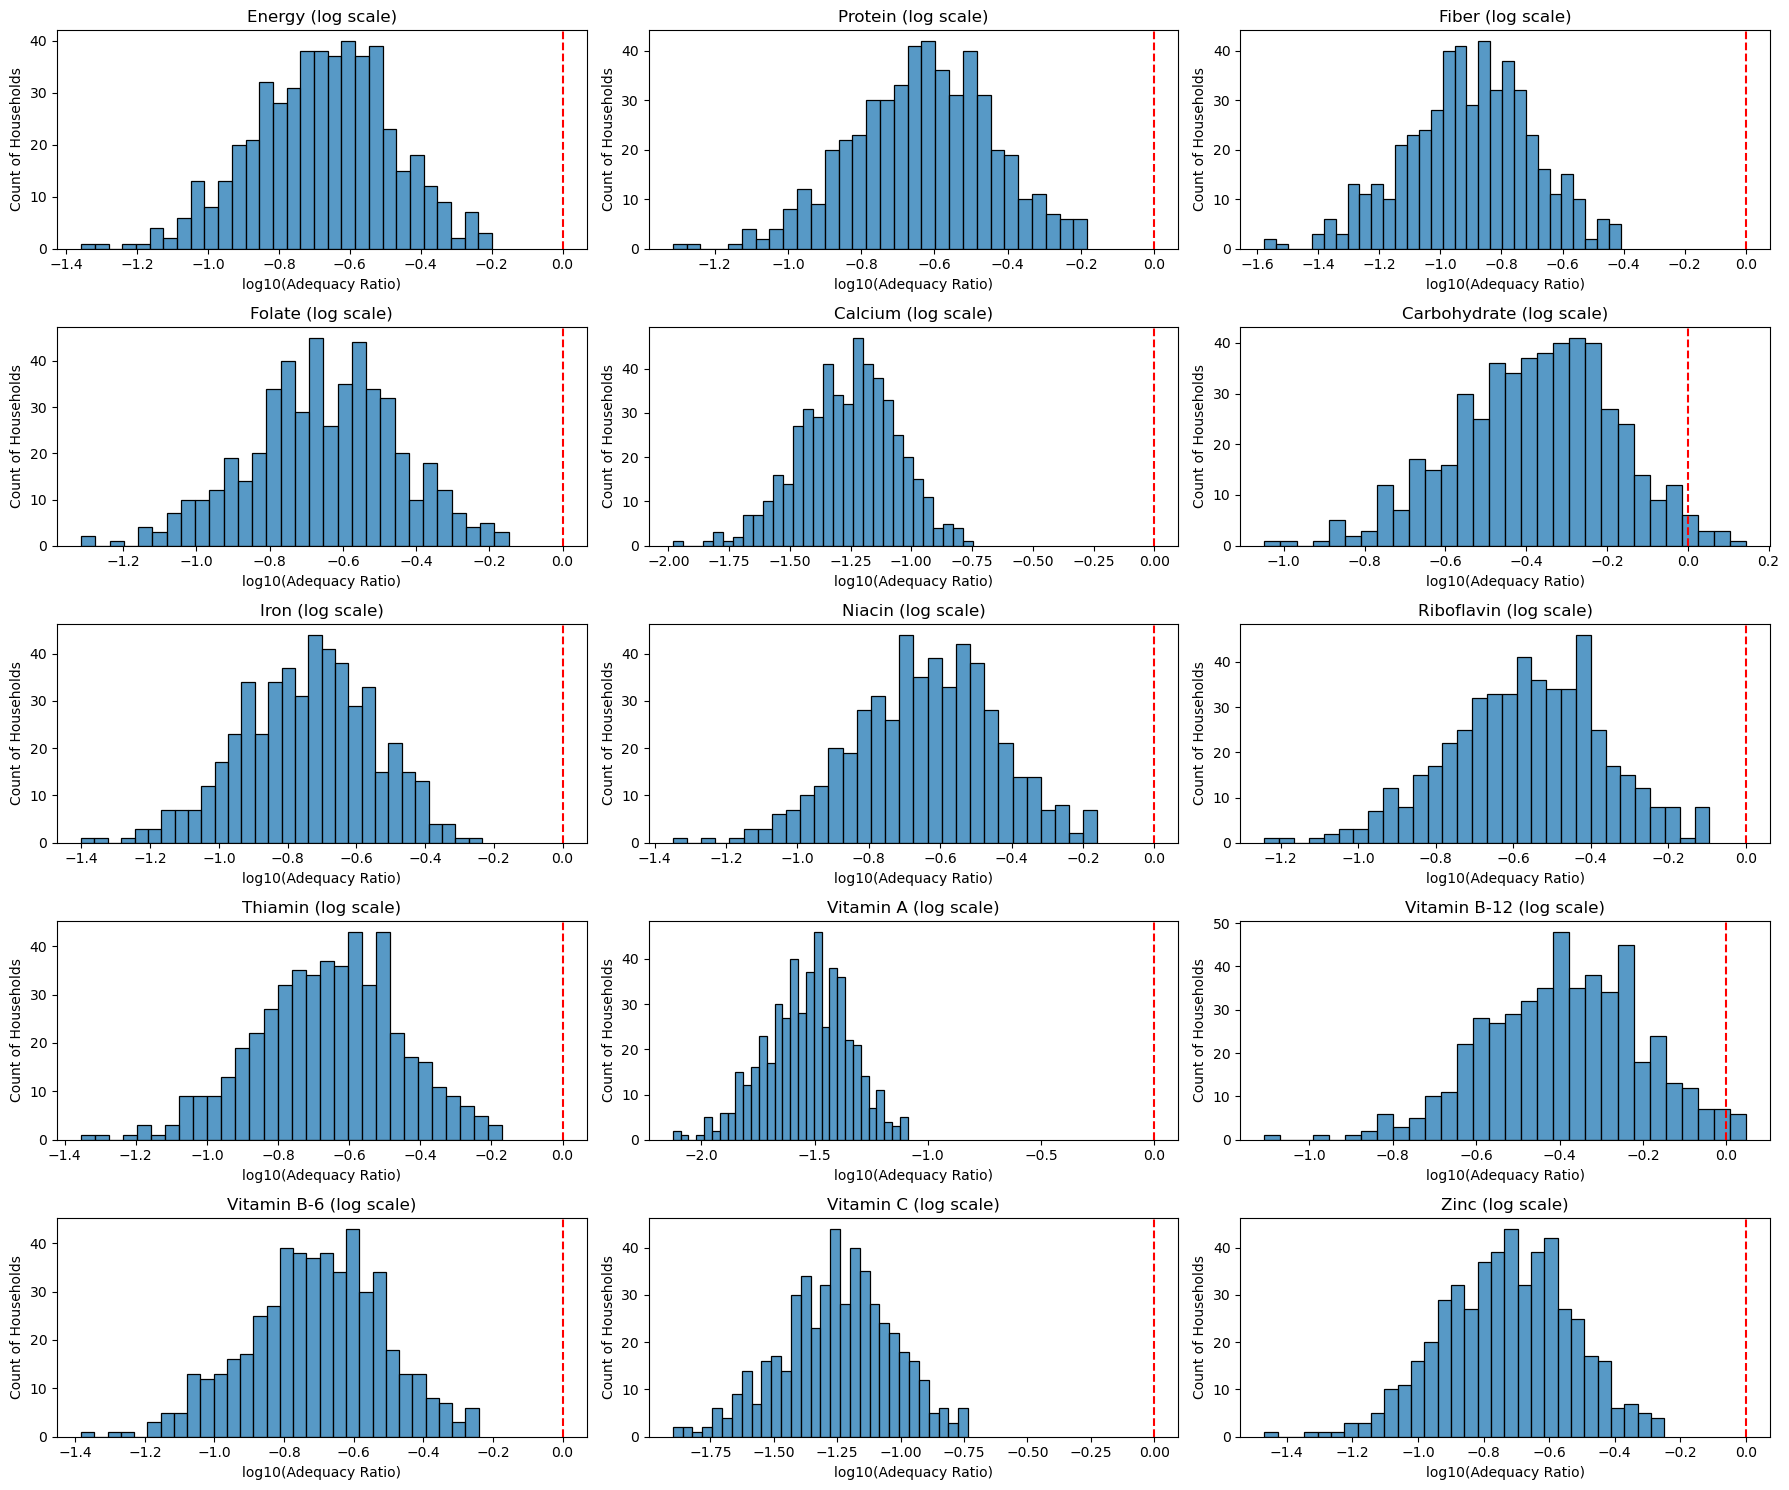

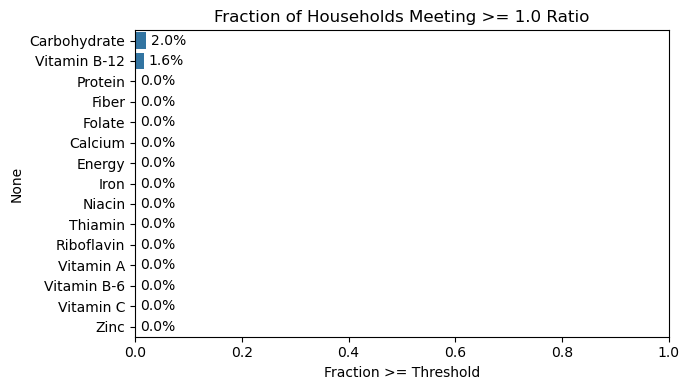

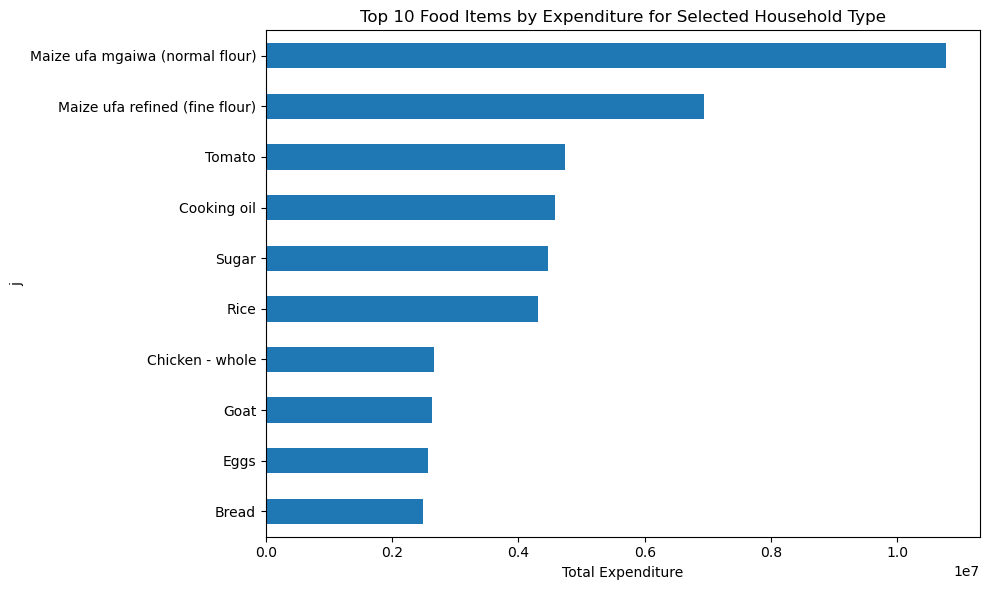

j
Maize ufa mgaiwa (normal flour)    10771598.0
Maize ufa refined (fine flour)      6943282.0
Tomato                              4739873.0
Cooking oil                         4579317.0
Sugar                               4470600.0
Rice                                4310261.0
Chicken - whole                     2658350.0
Goat                                2626256.0
Eggs                                2574608.0
Bread                               2487899.0
dtype: float64

In [45]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=1,       
    min_females=2, max_females=100,   
    min_kids=1, max_kids=100        
)
print(f'# households:{hhc_sub.shape}')
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=1,       # e.g. 0 adult males
    min_females=2, max_females=100,   # e.g. 1–3 adult females
    min_kids=1, max_kids=100)

#analyze_nutritional_adequacy(nut_sub)

# Household Characteristic 2) 1 Adult Males, 1 adult female 1+ kids (Nuclear Family)

# households:(2135, 17)
Average Weekly Food Expenditures: $37922.07 ($65.53 USD)


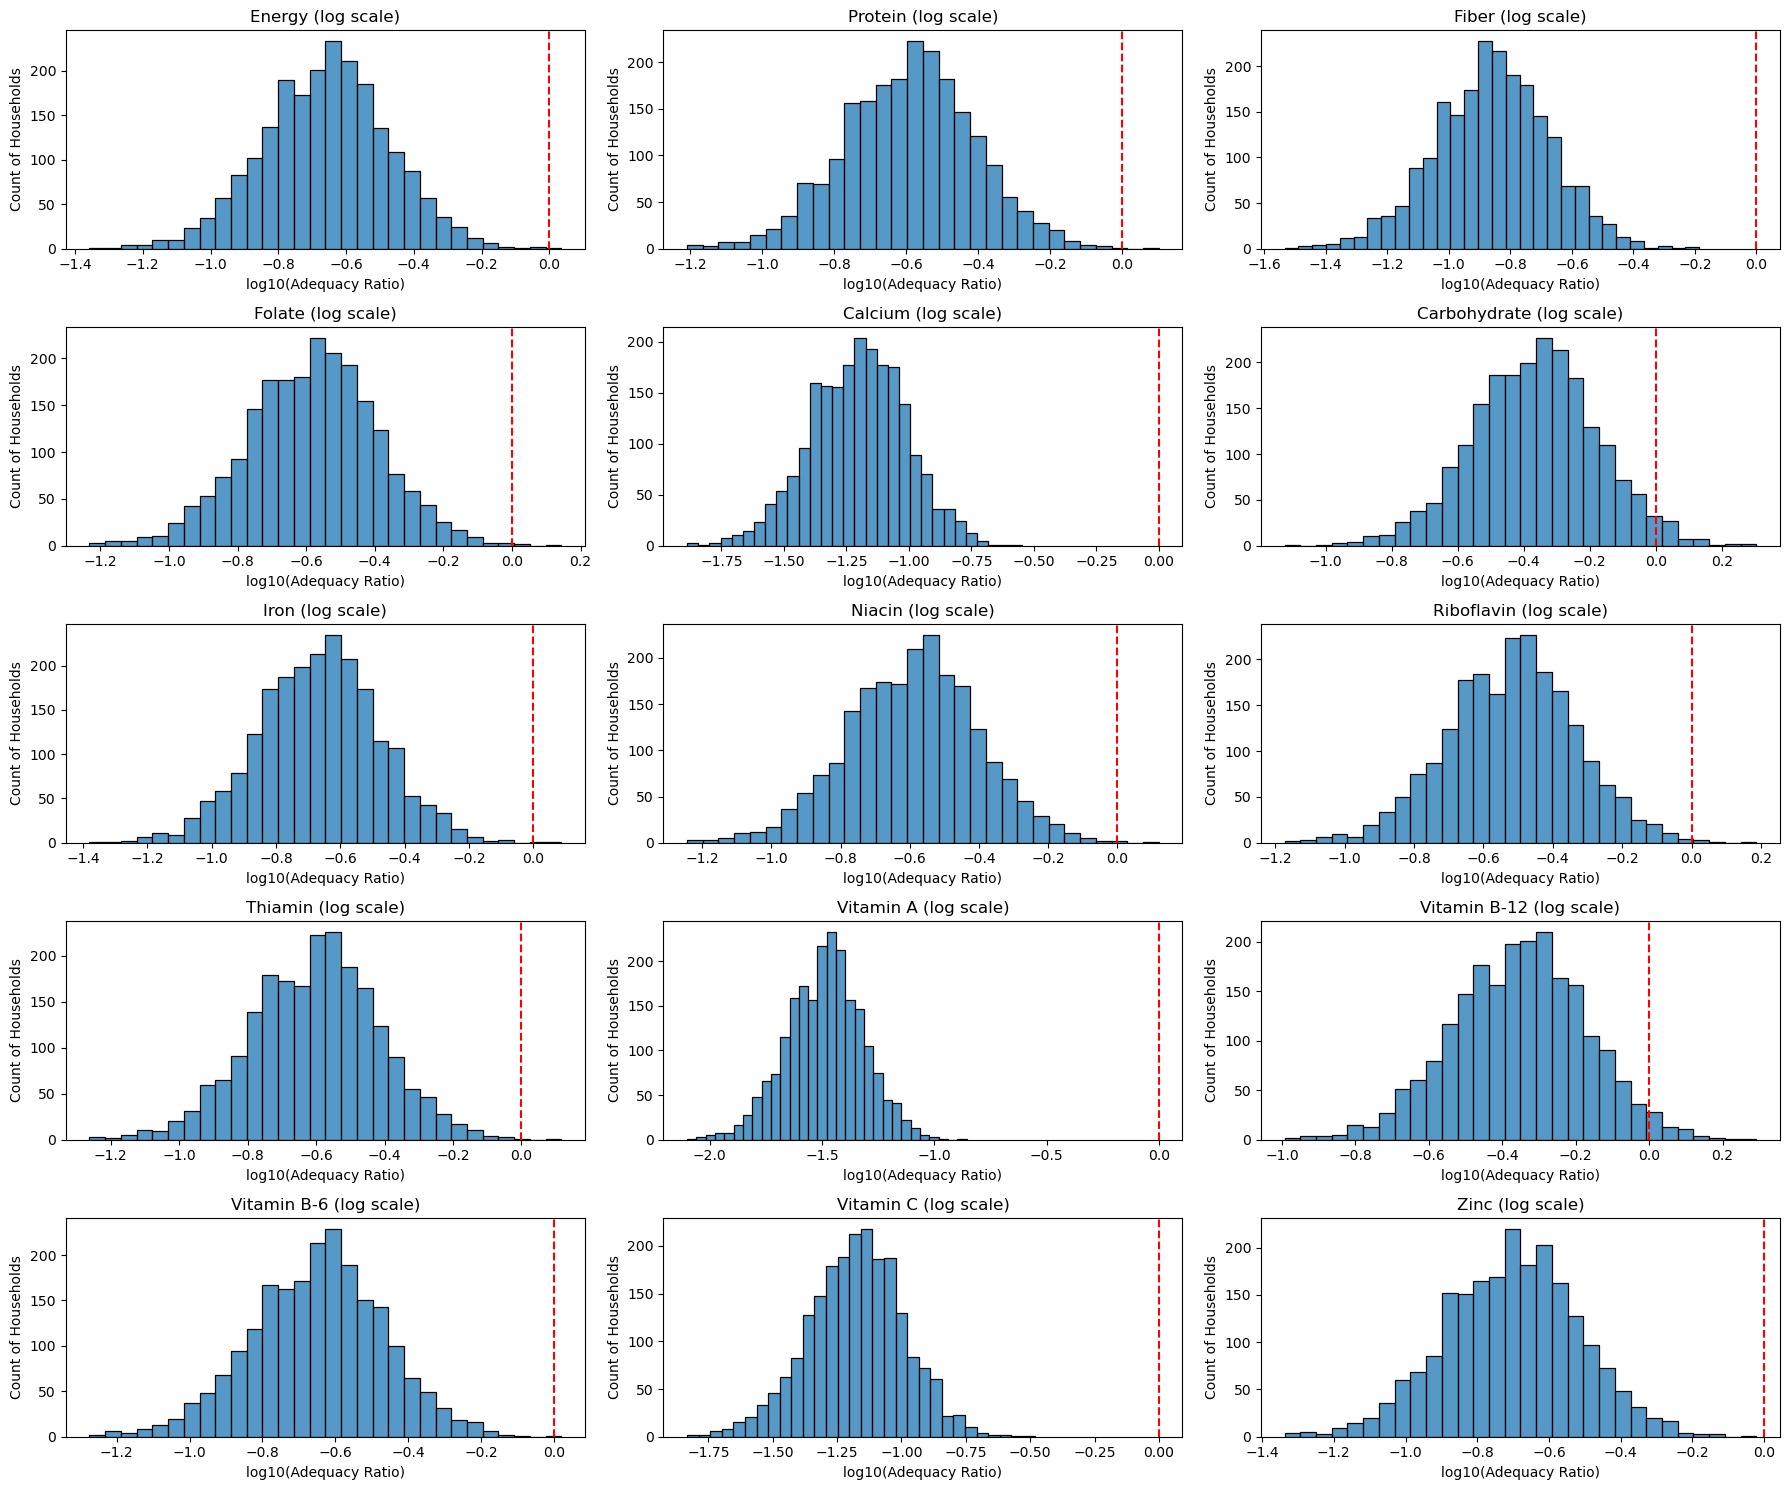

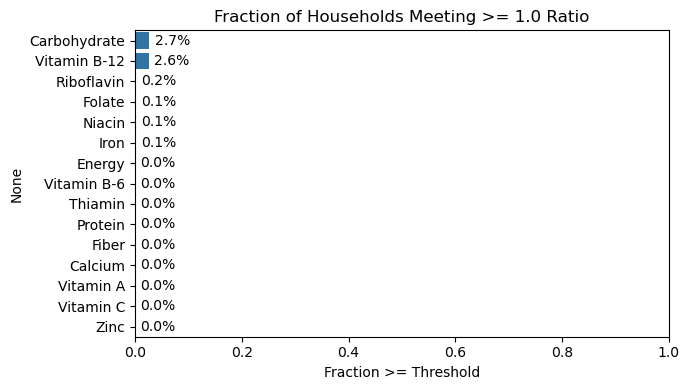

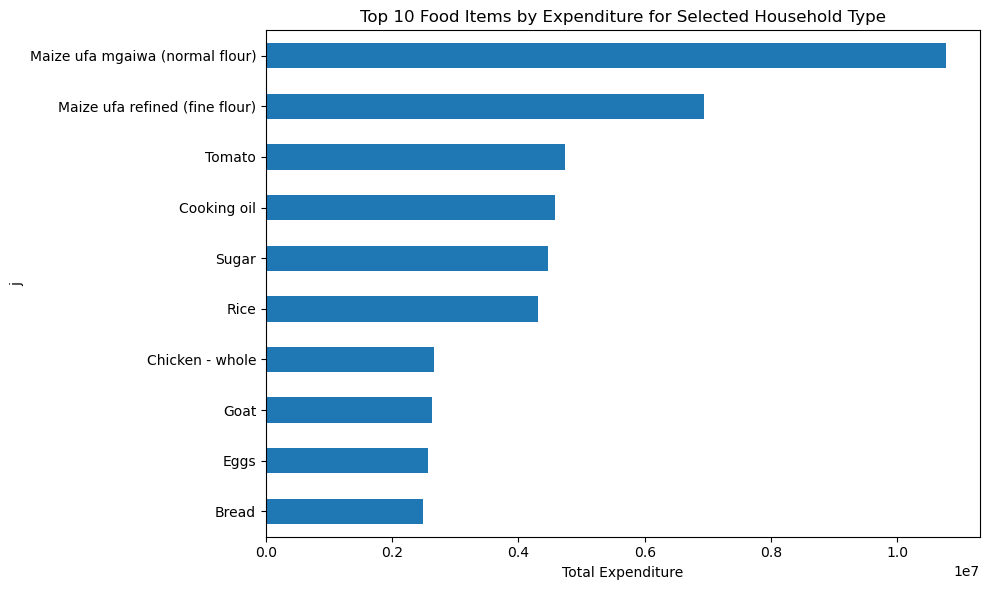

j
Maize ufa mgaiwa (normal flour)    10771598.0
Maize ufa refined (fine flour)      6943282.0
Tomato                              4739873.0
Cooking oil                         4579317.0
Sugar                               4470600.0
Rice                                4310261.0
Chicken - whole                     2658350.0
Goat                                2626256.0
Eggs                                2574608.0
Bread                               2487899.0
dtype: float64

In [46]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=1, max_males=1,       # e.g. 0 adult males
    min_females=1, max_females=1,   # e.g. 1–3 adult females
    min_kids=1, max_kids=100         # e.g. up to 2 kids
)

print(f'# households:{hhc_sub.shape}')
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')

analyze_nutritional_adequacy_subplots_log(nut_sub)

plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=1, max_males=1,       # e.g. 0 adult males
    min_females=1, max_females=1,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100)


# Household Characteristic- Men Only: 2+ Adult Males, 2+ adult female, 1-5 children

# households:(174, 17)
Average Weekly Food Expenditures: $54272.44 ($93.78 USD)


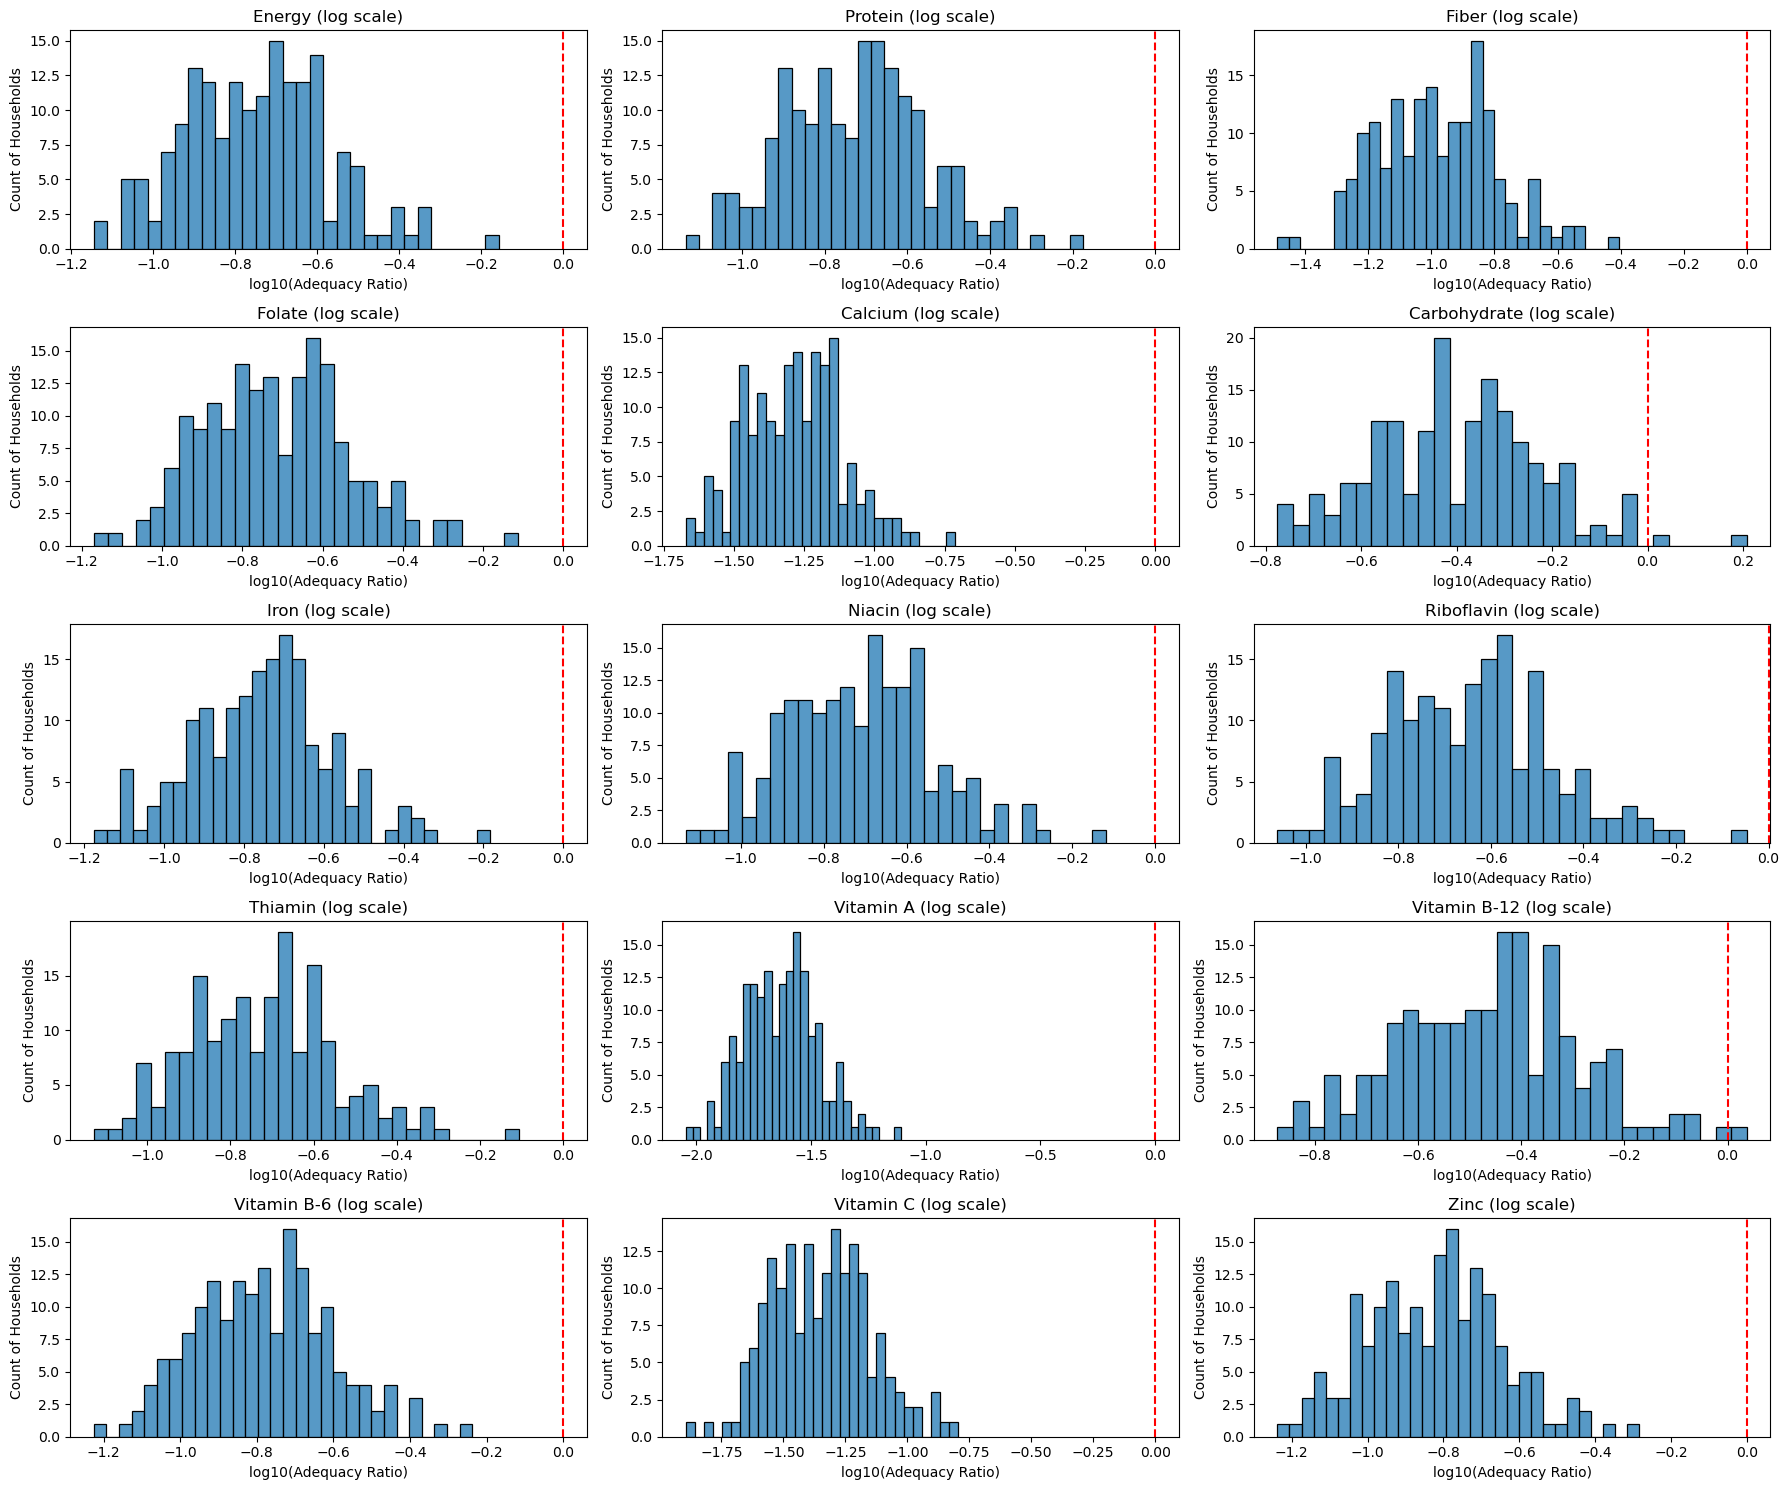

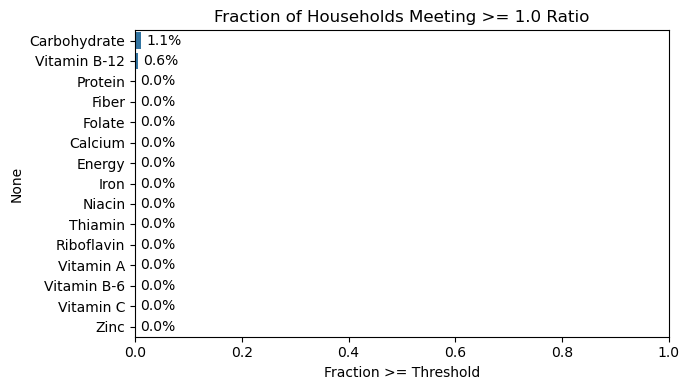

In [47]:

hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=2, max_males=100,       # e.g. 0 adult males
    min_females=2, max_females=100,   # e.g. 1–3 adult females
    min_kids=1, max_kids=5      # e.g. up to 2 kids
)
print(f'# households:{hhc_sub.shape}')
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)

# Changes in nutritional adequacy over time

In [73]:
expend = get_clean_sheet('./Data/Malawi_Food_Expenditures(2004-05).csv')
exp = get_clean_sheet(f'./Data/Malawi_Food_Expenditures(2004-05).csv')
    
exp_wide = expend.pivot_table(
        index=["i", "t", "m"],   # The keys identifying each row
        columns="j",            # The column you want to spread out
        values="Expenditure",   # What goes in the cells
        aggfunc="sum",          # How to aggregate if you have repeats
    )
    
    # If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
expend = exp_wide.reset_index()
    
if 'm' not in expend.columns:
    expend['m'] = 1
    
expend = expend.set_index(['i','t','m'])
expend.columns.name = 'j'
    
expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expend = expend.replace(0,np.nan)
    
    # Get HH characteristics...
hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
d = hhc.copy()
d.set_index(['i', 't', 'm'], inplace=True)

if 'm' not in hhc.columns:
    hhc['m'] = 1

hhc = hhc.set_index(['i','t','m'])
hhc.columns.name = 'k'

hhc = hhc.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Group expenditures and clean
x = pd.read_csv("./Data/Malawi_Food_Expenditures(2019-20).csv", header= 0, index_col=0).reset_index()
x = x.set_index(['i', 't', 'm', 'j']).squeeze()
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x

i             t        m         j                                               
101011000014  2019-20  North     Chinese cabbage                                     200
                                 Chips (vendor)                                      500
                                 Cooking oil                                         200
                                 Onion                                               100
                                 Salt                                                150
                                                                                    ... 
315538160239  2019-20  Southern  Salt                                                 50
                                 Soft drinks (coca-cola, fanta, sprite, etc)         500
                                 Termites, other insects (eg ngumbi, caterpillar)    200
                                 Thobwa                                              200
                            

In [84]:
rdi = get_clean_sheet('./Data/RDI.csv')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'
#rdi = rdi.drop(columns=["Unnamed: 0"])
rdi.columns.to_list()

['F 00-03',
 'M 00-03',
 'F 04-08',
 'M 04-08',
 'F 09-13',
 'M 09-13',
 'F 14-18',
 'M 14-18',
 'F 19-30',
 'M 19-30',
 'F 31-50',
 'M 31-50',
 'F 51+',
 'M 51+']

In [95]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures by year
def nutritional_yearly_analysis(year_range):
    expend = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    exp = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    
    exp_wide = expend.pivot_table(
        index=["i", "t", "m"],   # The keys identifying each row
        columns="j",            # The column you want to spread out
        values="Expenditure",   # What goes in the cells
        aggfunc="sum",          # How to aggregate if you have repeats
    )
    
    # If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
    expend = exp_wide.reset_index()
    
    if 'm' not in expend.columns:
        expend['m'] = 1
    
    expend = expend.set_index(['i','t','m'])
    expend.columns.name = 'j'
    
    expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    expend = expend.replace(0,np.nan)
    
    # Get HH characteristics...
    hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
    d = hhc.copy()
    
    d.set_index(['i', 't', 'm'], inplace=True)
    #d = d.drop(columns=["Unnamed: 0"])
    d.columns.name = 'k'

    if 'm' not in hhc.columns:
        hhc['m'] = 1
    
    hhc = hhc.set_index(['i','t','m'])
    hhc.columns.name = 'k'
    hhc = hhc.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    
    # Group expenditures and clean
    # Group expenditures and clean
    x = pd.read_csv(f"./Data/Malawi_Food_Expenditures({year_range}).csv", header= 0, index_col=0).reset_index()
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    
    # Take logs of expenditures
    y = np.log(x)
    
    result = Regression(y=y,d=d)
    # Save the regression result
    result.to_pickle(f'malawi_estimates({year_range}).rgsn')
    
    # Get prices
    p = pd.read_csv(f"./Data/Malawi_Food_Prices({year_range}).csv")
    
    # Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
    #p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")
    
    # Convert to numeric if needed
    p["Price"] = pd.to_numeric(p["Price"], errors="coerce")
    
    # Pivot so each unique `j` becomes a column and
    # each (t, m) is one row
    p_wide = p.pivot_table(
        index=["t","m"],
        columns="j",
        values="Price",
        aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
    ) #.reset_index()
    
    p_wide.columns.name = None  # remove the pivoted index name if desired
    
    p = p_wide #.set_index('t')
    
    fct = get_clean_sheet('./Data/FCT.csv')
    
    #### This bit peculiar to Niger FCT #####
    #fct = fct.loc[fct.Code.str.len()==6]
    #fct = fct.set_index('Code')
    #fct.columns = [v.replace('\n',' ') for v in fct.columns]
    ########################################
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    
    fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    
    ################## RDI, if available (consider using US) #####################
    rdi = get_clean_sheet('./Data/RDI.csv')
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    

    #predicted expenditures
    #result = cfe.regression.read_pickle(f'malawi_estimates({year_range}).rgsn')
    
    xhat = result.predicted_expenditures()
    
    # Expenditures divided by prices/kg gives quantities in kgs...
    qhat = (xhat.unstack('j')/p).dropna(how='all')
    
    
    # Drop missing columns
    qhat = qhat.loc[:,qhat.count()>0]
    use = fct.index.intersection(qhat.columns)
    nutrients = qhat[use]@fct.loc[use,:]
    nutrients.mean()    
   
    hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
    hhc.columns = hhc.columns.str.replace("51-99", "51+")
    hhc = hhc[rdi.columns.tolist()]
    hh_rdi = hhc@rdi.T 
    #z = # ppl in household , rdi => add up all ppl in household
    hh_rwi = hh_rdi*7
 
    # Match up nutrient names
    use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
    
    nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
    #hh_rwi = required nutrients per week. 1 = adequate intake, <1 = not adequate
    #%matplotlib inline
    #nutrient_ratio['Protein'].hist(bins=200)
    #plt.xlim(0, 5)
    
    nutrient_ratio
    #xhat.unstack('j')
    # return expend, p, hhc, nutrient_ratio
    return nutrients

In [96]:
df_1 = nutritional_yearly_analysis('2004-05')

In [97]:
df_1

,,n,k,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,,
20101008061,2004-05,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20101008100,2004-05,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20101008128,2004-05,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20101008193,2004-05,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20102009069,2004-05,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31202086188,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31202086288,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31202086289,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
expenditures_0405, p_0405, hhc_0405, nutritional_ratio_0405 = nutritional_yearly_analysis('2004-05')


In [91]:
nutritional_ratio_0405

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
10101002246,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101003013,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101003017,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101003020,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101003062,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31202086188,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31202086288,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31202086289,2004-05,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Regional Differences
## Note: lots of nuance lost in splitting into regions. Quick tool to see the range of differences

In [ ]:
hhc

In [ ]:
expend

In [ ]:
import pandas as pd
import plotly.express as px
import json

with open("sn.json") as f:
    senegal_geo = json.load(f)
# Or using geopandas:
gdf = gpd.read_file("sn.json")


# 3) Create the choropleth
#    We'll use an animation slider for nutrient selection. Each "frame" in the slider is a different nutrient.
fig = px.choropleth(
    region_nutrient_df,
    geojson=senegal_geo,
    locations='region',         # Column in region_nutrient_df that matches GeoJSON features' property
    featureidkey='properties.region_name_in_geojson', 
    # ^^^ Adjust to the property name in your geojson that stores the region's name. 
    color='fraction_meeting',
    color_continuous_scale='YlOrRd',
    range_color=(0,1),          # fraction_meeting from 0% to 100% (0-1)
    scope='africa',             # "africa" or use fig.update_geos(...)
    hover_name='region',        # Display region name on hover
    animation_frame='nutrient', # This tells Plotly to create an animation slider for different nutrients
)

# 4) Customize the hover template, layout, etc.
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                  "Fraction meeting: %{z:.1%}<extra></extra>"
)
fig.update_layout(
    title="Senegal: % of Households Meeting Recommended Nutrient Intake",
    margin={"r":0,"t":50,"l":0,"b":0}
)
fig.update_geos(fitbounds="locations", visible=False)

fig.show()


In [ ]:
def filter_regions(hhc, nutrient_ratio, regions):
    """
    Return rows (households) from hhc and nutrient_ratio
    where the 'm' index level is in the given list of regions.

    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Build a Boolean mask selecting only desired regions
    #    We take the 'm' level of the index and check if it is in `regions`.
    mask = hhc.index.get_level_values('m').isin(regions)

    # 2) Apply this mask to both dataframes
    hhc_filtered = hhc.loc[mask].copy()

    # 3) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    return hhc_filtered, nutrient_filtered

    #nutrient_filtered = nutrient_ratio.loc[mask].copy()

    #return hhc_filtered, nutrient_filtered


In [ ]:
hhc.index.get_level_values("m").unique()

In [ ]:
nutrient_ratio

# Urban regions

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, ['dakar'])
analyze_nutritional_adequacy_subplots_log(nutrient_sub)

In [ ]:
hhc_sub.shape

# More Rural Regions 

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, rural_regions)
analyze_nutritional_adequacy_subplots_log(nutrient_sub)



In [ ]:
hhc_sub.shape